In [58]:
# Import
import osmnx as ox 
import matplotlib as mpl 
%matplotlib inline
from matplotlib import pyplot as plt
import os
import pandas as pd
import geopandas as gpd
import numpy as np
# Set up query
query = {'amenity':'restaurant'}

# Run query
restaurants_gdf = ox.geometries.geometries_from_place(
            'Greater London, UK',
            tags = query)

restaurants_gdf.head(5)

amenity                 name  \
element_type osmid                                       
node         451153    restaurant   Central Restaurant   
             26544484  restaurant       Casuarina Tree   
             26603928  restaurant         Karma Lounge   
             26604024  restaurant               Jin Li   
             26845558  restaurant  Old Tree Daiwan Bee   

                                        geometry addr:city addr:housename  \
element_type osmid                                                          
node         451153    POINT (-0.19350 51.60203)       NaN            NaN   
             26544484  POINT (-0.17223 51.39801)   Mitcham  The Crown Inn   
             26603928  POINT (-0.48171 51.52718)       NaN            NaN   
             26604024  POINT (-0.45855 51.52573)  Uxbridge            NaN   
             26845558  POINT (-0.13256 51.51105)       NaN            NaN   

                      addr:housenumber addr:postcode       addr:street  \
element_type osmid                                                       
node         451153                NaN           NaN               NaN   
             26544484              407       CR4 4BG       London Road   
             26603928              NaN           NaN               NaN   
             26604024               91       UB8 3NJ  Pield Heath Road   
             26845558              NaN           NaN               NaN   

                       cuisine fhrs:authority  ... note:name:en note:name:zh  \
element_type osmid                             ...                             
node         451153        NaN            NaN  ...          NaN          NaN   
             26544484   indian         Merton  ...          NaN          NaN   
             26603928      NaN            NaN  ...          NaN          NaN   
             26604024  chinese            NaN  ...          NaN          NaN   
             26845558   taiwan            NaN  ...          NaN          NaN   

                      website:en serving_system:buffet fixme:addr4  \
element_type osmid                                                   
node         451153          NaN                   NaN         NaN   
             26544484        NaN                   NaN         NaN   
             26603928        NaN                   NaN         NaN   
             26604024        NaN                   NaN         NaN   
             26845558        NaN                   NaN         NaN   

                      nohousenumber ref:GB:uprn diet:local source:outline ways  
element_type osmid                                                              
node         451153             NaN         NaN        NaN            NaN  NaN  
             26544484           NaN         NaN        NaN            NaN  NaN  
             26603928           NaN         NaN        NaN            NaN  NaN  
             26604024           NaN         NaN        NaN            NaN  NaN  
             26845558           NaN         NaN        NaN            NaN  NaN  

[5 rows x 378 columns]

C:\Users\hp\AppData\Local\Temp\ipykernel_6664\2915484117.py:10: UserWarning: Legend does not support handles for PatchCollection instances.
See: https://matplotlib.org/stable/tutorials/intermediate/legend_guide.html#implementing-a-custom-legend-handler
  plt.legend()


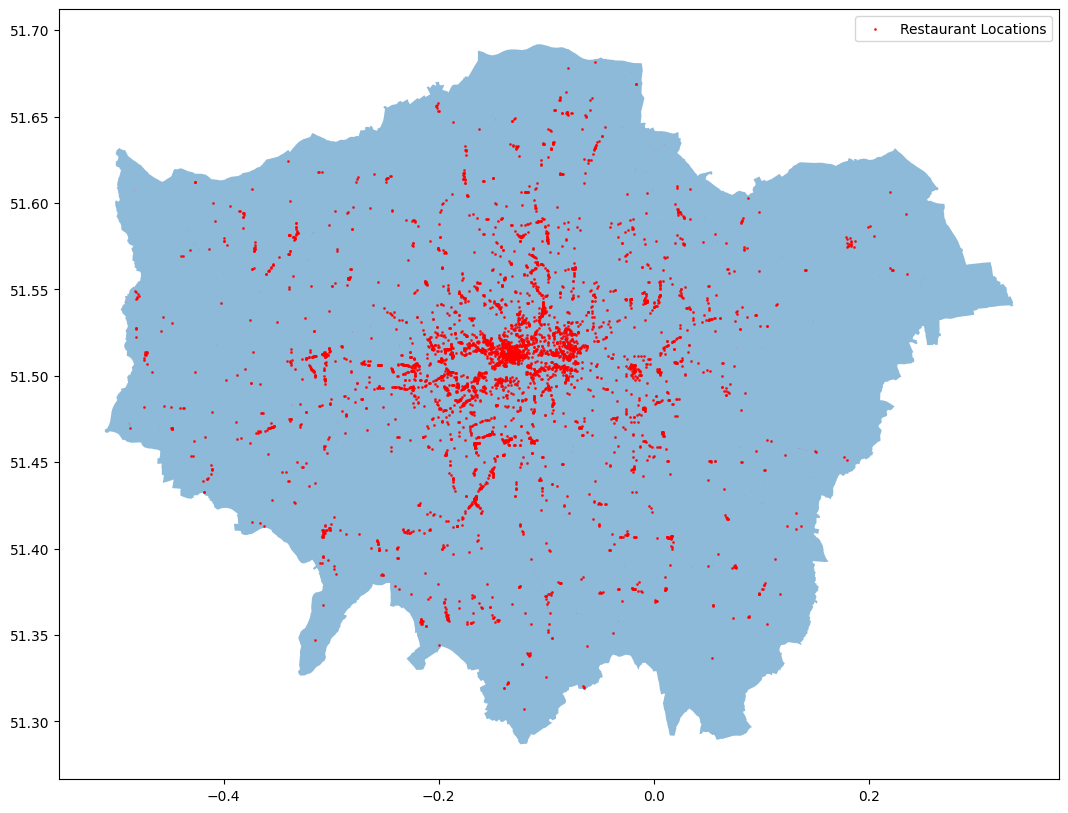

In [59]:
# Download London's Boundary
london_gdf = ox.geocoder.geocode_to_gdf('Greater London, UK')

# Set up a plot axis
fig, ax = plt.subplots(figsize = (15,10))

# Visualise both on the plot
london_gdf.plot(ax = ax, alpha = 0.5)
restaurants_gdf.plot(ax = ax, markersize = 1, color = 'red', alpha = 0.8, label = 'Restaurant Locations')
plt.legend()



In [60]:
from shapely.geometry.polygon import Polygon
from shapely.geometry.multipolygon import MultiPolygon

london_gdf['geometry'] = london_gdf['geometry'].apply(
  lambda x: x.centroid if type(x) == Polygon else (
  x.centroid if type(x) == MultiPolygon else x)
)

In [61]:
def get_local_crs(y,x):  
    x = ox.utils_geo.bbox_from_point((y, x), dist = 500, project_utm = True, return_crs = True)
    return x[-1]
  
# Set London longitude and latitude
lon_latitude = 51.509865
lon_longitude = -0.118092

local_utm_crs = get_local_crs(lon_latitude, lon_longitude)

In [62]:

# Import our AirBnb room data
path = os.path.join('c:' + os.sep, 'Users', 'hp', 'Accessing-OpenStreetMap-Data', 'airbnb_rooms.csv')
air_df = pd.read_csv(path)

# Note below: "crs = 4326" is our way of telling geopandas that the initial projection uses the standard
# longitude latitude coordinates. You can't manipulate the CRS if you haven't set one initially.

air_gdf = gpd.GeoDataFrame(air_df, geometry = gpd.points_from_xy(air_df.longitude, air_df.latitude), crs = 4326)
air_gdf = air_gdf.to_crs(local_utm_crs)

#Convert amenities into local projection (amenities already had an initial CRS set when we downloaded it via OSMnx)
restaurants_gdf = restaurants_gdf.to_crs(local_utm_crs)

In [63]:
import time
from scipy import spatial
from scipy.spatial import KDTree

points = restaurants_gdf[restaurants_gdf.geometry.type == 'Point']
Lon = points.geometry.apply(lambda x: x.x).values
Lat = points.geometry.apply(lambda x: x.y).values
coords = list(zip(Lat,Lon))
tree = spatial.KDTree(coords)
# Lon = []
# Lat = []
# for geom in restaurants_gdf.geometry:
#     if geom.type == 'Point':
#         Lon.append(geom.x)
#         Lat.append(geom.y)
#     elif geom.type == 'Polygon':
#         Lon.append(geom.centroid.x)
#         Lat.append(geom.centroid.y)
# coords = list(zip(Lat, Lon))
# tree = spatial.KDTree(coords)

In [64]:
def find_points_closeby(lat_lon, k = 500, max_distance = 1000 ):
  '''
  Queries a pre-existing kd tree and returns the number of points within x distance
  of long/lat point.
  lat_lon:        A longitude and latitude pairings in the (y, x) tuple form.
  k:              The maximum number of closest points to query
  max_distance:   The maximum distance (in meters)
  '''
  
  results = tree.query((lat_lon), k = k, distance_upper_bound= max_distance)
  zipped_results = list(zip(results[0], results[1]))
  zipped_results = [i for i in zipped_results if i[0] != np.inf]
  
  return len(zipped_results)

In [65]:
# Set up a timer 
import time 
t0 = time.time()

#Apply the function
air_gdf['restaurants'] = air_gdf.apply(lambda row: find_points_closeby(
  (row.geometry.y, row.geometry.x)) , axis = 1)

# Report the time
time_passed = round(time.time() - t0, 2)
print ("Completed in %s seconds" % (time_passed))

Completed in 41.35 seconds


In [66]:
air_gdf[['id','restaurants']].head(5)

,id,restaurants
0,13913,45
1,15400,125
2,17402,147
3,25023,0
4,25123,9
